<a href="https://colab.research.google.com/github/Sevnhutsjr/ST311_Group11_Project/blob/main/images_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Loading Images and Exploring the Emotion Image Data
- By Group 11

This notebook builds a Convolutional Neural Network (CNN) from scratch using PyTorch to classify facial expressions into seven emotion categories:
- angry
- disgusted
- fearful
- happy
- neutral
- sad
- surprised.



In [3]:
## Imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os


Downloading the Data

In [10]:
# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotion-detection-fer


In [11]:
import os

base_path = "/kaggle/input/emotion-detection-fer"
for root, dirs, files in os.walk(base_path):
    print(root)


/kaggle/input/emotion-detection-fer
/kaggle/input/emotion-detection-fer/test
/kaggle/input/emotion-detection-fer/test/fearful
/kaggle/input/emotion-detection-fer/test/disgusted
/kaggle/input/emotion-detection-fer/test/angry
/kaggle/input/emotion-detection-fer/test/neutral
/kaggle/input/emotion-detection-fer/test/sad
/kaggle/input/emotion-detection-fer/test/surprised
/kaggle/input/emotion-detection-fer/test/happy
/kaggle/input/emotion-detection-fer/train
/kaggle/input/emotion-detection-fer/train/fearful
/kaggle/input/emotion-detection-fer/train/disgusted
/kaggle/input/emotion-detection-fer/train/angry
/kaggle/input/emotion-detection-fer/train/neutral
/kaggle/input/emotion-detection-fer/train/sad
/kaggle/input/emotion-detection-fer/train/surprised
/kaggle/input/emotion-detection-fer/train/happy


Doing some EDA to check the data

In [ ]:
base_dir = "/kaggle/input/emotion-detection-fer"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Check paths exist
print("Checking directories...")
for path in [base_dir, train_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ Path does not exist: {path}")
    else:
        print(f"✅ Found: {path}")

# Get emotion class names
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)


Checking directories...
✅ Found: /kaggle/input/emotion-detection-fer
✅ Found: /kaggle/input/emotion-detection-fer/train
✅ Found: /kaggle/input/emotion-detection-fer/test
Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


Class Distribution in Train and Test Sets

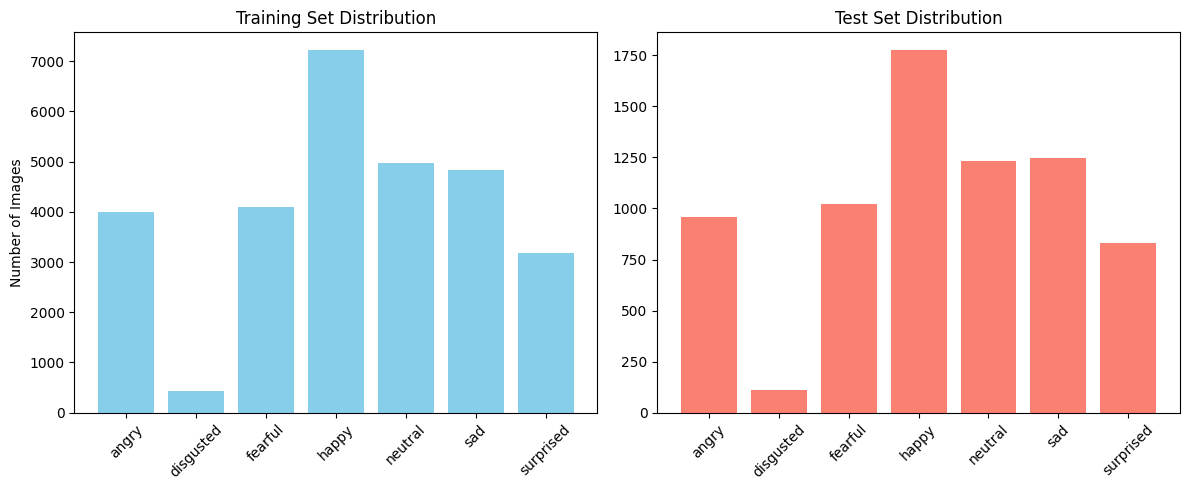

In [ ]:
# Count samples per class
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(test_counts.keys(), test_counts.values(), color='salmon')
axes[1].set_title('Test Set Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Sample Image from Each Emotion Class

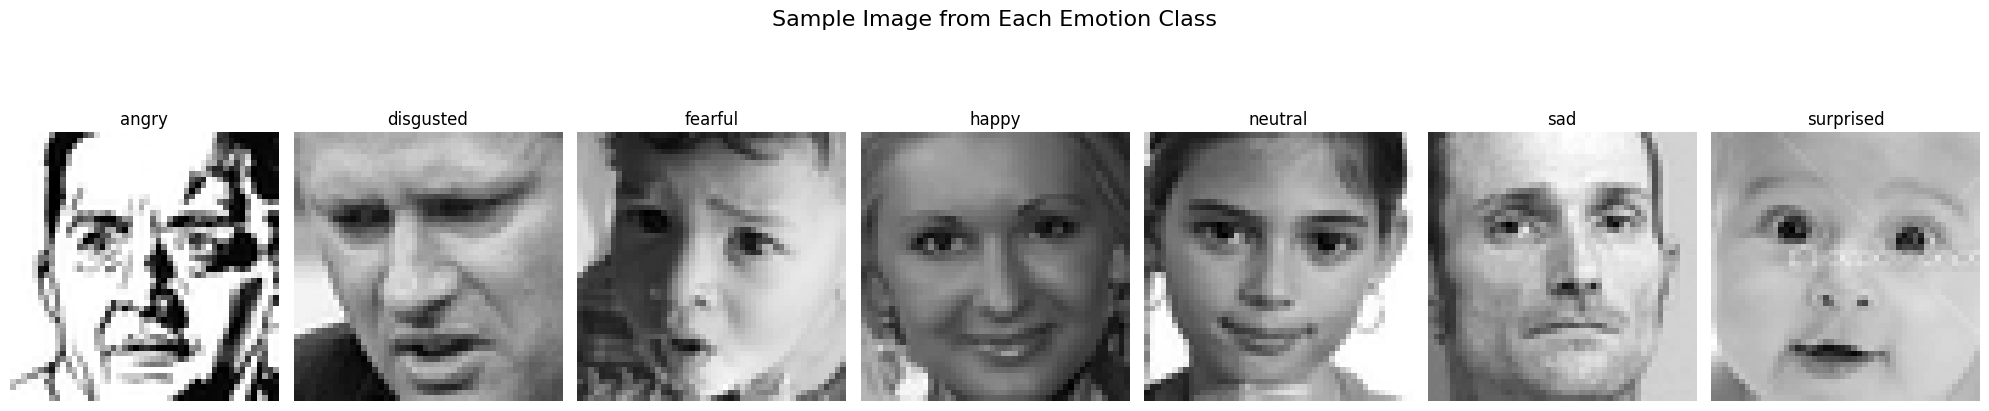

In [ ]:
# Show one image per emotion
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
for idx, cls in enumerate(class_names):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = Image.open(img_path)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(cls)
    axes[idx].axis('off')

plt.suptitle("Sample Image from Each Emotion Class", fontsize=16)
plt.tight_layout()
plt.show()


Image Size Consistency Check

In [ ]:
# Check for consistent image sizes
img_sizes = []
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_path)[:100]:  # sample 100 per class
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path)
        img_sizes.append(img.size)

img_sizes = np.array(img_sizes)
unique_sizes, counts = np.unique(img_sizes, axis=0, return_counts=True)

print("\n✅ Image Size Summary:")
for sz, ct in zip(unique_sizes, counts):
    print(f"  Size {tuple(sz)} → {ct} images")



✅ Image Size Summary:
  Size (np.int64(48), np.int64(48)) → 700 images


Pixel Intensity Histogram per Class

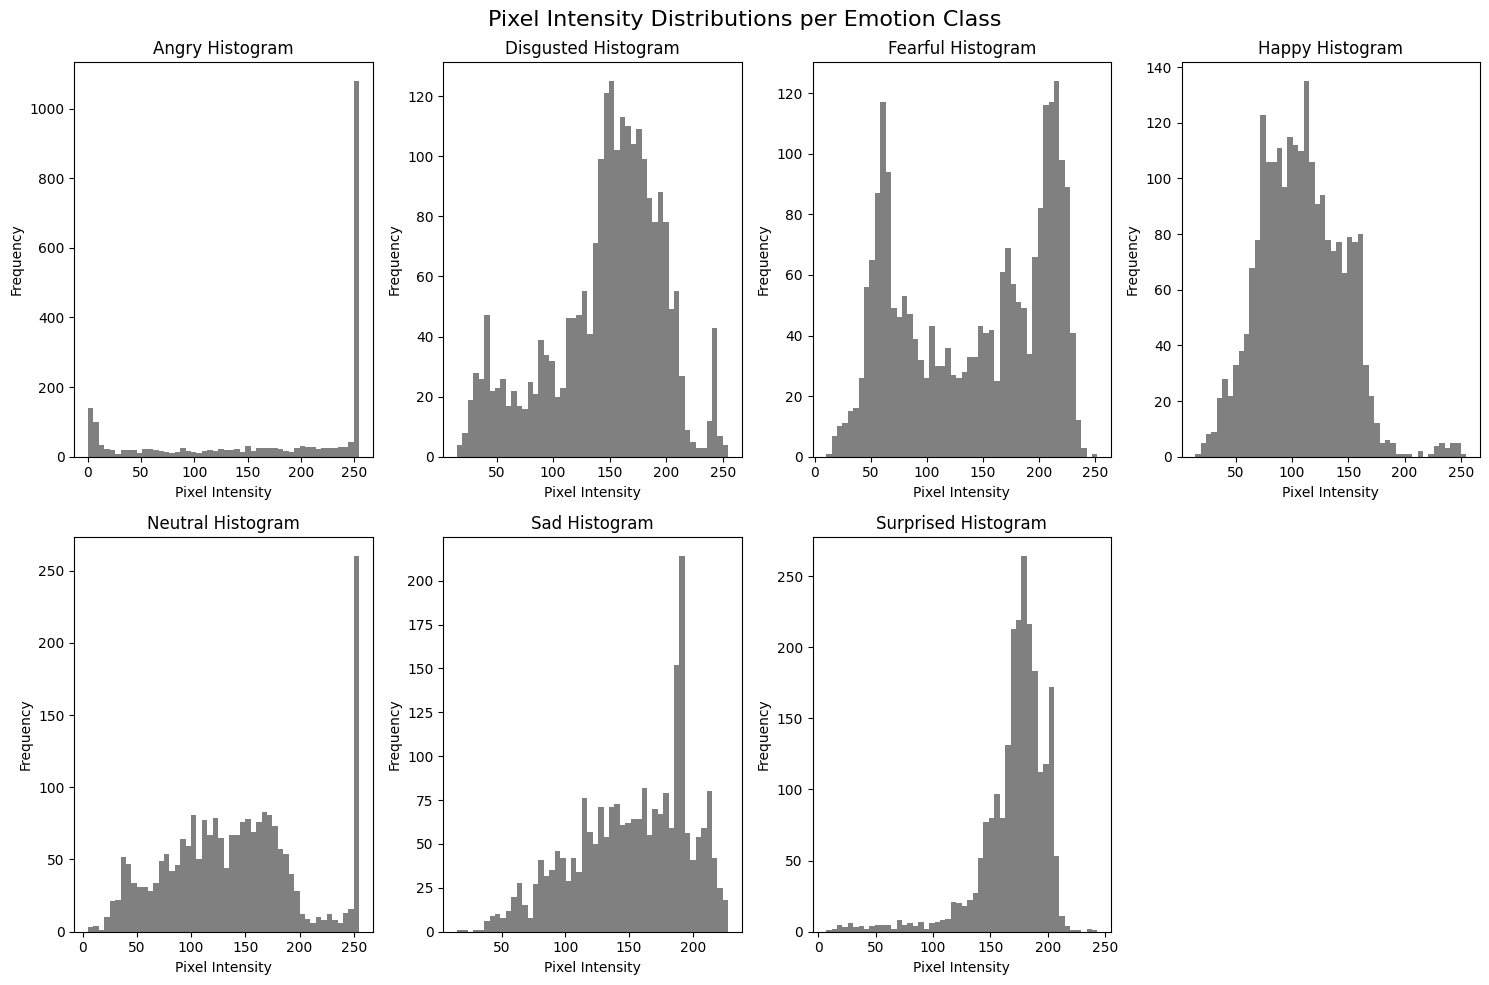

In [ ]:
plt.figure(figsize=(15, 10))
for i, cls in enumerate(class_names):
    class_path = os.path.join(train_dir, cls)
    sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 4, i + 1)
    plt.hist(sample_img.ravel(), bins=50, color='gray')
    plt.title(f"{cls.capitalize()} Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.suptitle("Pixel Intensity Distributions per Emotion Class", fontsize=16)
plt.tight_layout()
plt.show()


Baseline Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = "/kaggle/input/emotion-detection-fer/train"
test_dir = "/kaggle/input/emotion-detection-fer/test"

# (grayscale 48x48)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# Baseline CNN Model
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.fc = nn.Linear(8 * 48 * 48, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = BaselineCNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
def train_baseline(model, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} | Test Accuracy: {accuracy:.4f}")

train_baseline(model, num_epochs=5)


Epoch 1/5 | Test Accuracy: 0.3481
Epoch 2/5 | Test Accuracy: 0.3456
Epoch 3/5 | Test Accuracy: 0.3697
Epoch 4/5 | Test Accuracy: 0.3704
Epoch 5/5 | Test Accuracy: 0.4093


Fine Tuned Model

Epoch 1/25 | Loss: 1.7590 | Test Accuracy: 0.3866
Epoch 2/25 | Loss: 1.6427 | Test Accuracy: 0.4489
Epoch 3/25 | Loss: 1.5563 | Test Accuracy: 0.4742
Epoch 4/25 | Loss: 1.5075 | Test Accuracy: 0.4996
Epoch 5/25 | Loss: 1.4713 | Test Accuracy: 0.5135
Epoch 6/25 | Loss: 1.4383 | Test Accuracy: 0.5132
Epoch 7/25 | Loss: 1.4121 | Test Accuracy: 0.5325
Epoch 8/25 | Loss: 1.3799 | Test Accuracy: 0.5325
Epoch 9/25 | Loss: 1.3501 | Test Accuracy: 0.5577
Epoch 10/25 | Loss: 1.3197 | Test Accuracy: 0.5599
Epoch 11/25 | Loss: 1.2914 | Test Accuracy: 0.5794
Epoch 12/25 | Loss: 1.2595 | Test Accuracy: 0.5752
Epoch 13/25 | Loss: 1.2318 | Test Accuracy: 0.5943
Epoch 14/25 | Loss: 1.1890 | Test Accuracy: 0.5954
Epoch 15/25 | Loss: 1.1530 | Test Accuracy: 0.6018
Epoch 16/25 | Loss: 1.1147 | Test Accuracy: 0.6094
Epoch 17/25 | Loss: 1.0730 | Test Accuracy: 0.6121
Epoch 18/25 | Loss: 1.0338 | Test Accuracy: 0.6158
Epoch 19/25 | Loss: 0.9977 | Test Accuracy: 0.6176
Epoch 20/25 | Loss: 0.9647 | Test Accura

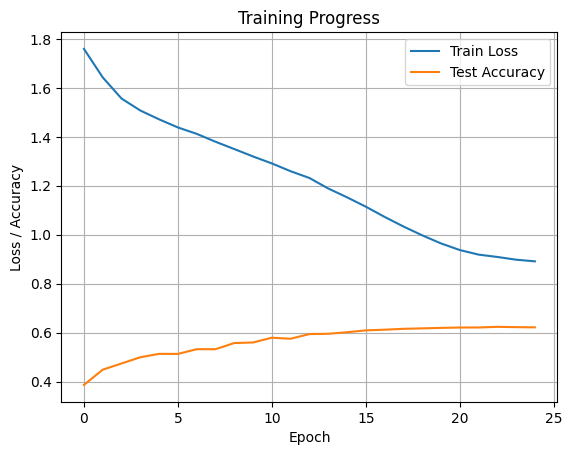

✅ Model saved to: /content/emotion_cnn_model.pt


In [ ]:
# Model

# Dataset paths
train_dir = "/kaggle/input/emotion-detection-fer/train"
test_dir = "/kaggle/input/emotion-detection-fer/test"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# CNN Model
class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Model setup
model = EmotionCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Training loop
def train_model(model, num_epochs=25):
    train_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        test_accuracies.append(acc)
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Accuracy: {acc:.4f}")

    return train_losses, test_accuracies

train_losses, test_accuracies = train_model(model, num_epochs=25)

plt.plot(train_losses, label='Train Loss')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Save model in Colab
model_path = "/content/emotion_cnn_model.pt"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")


Results

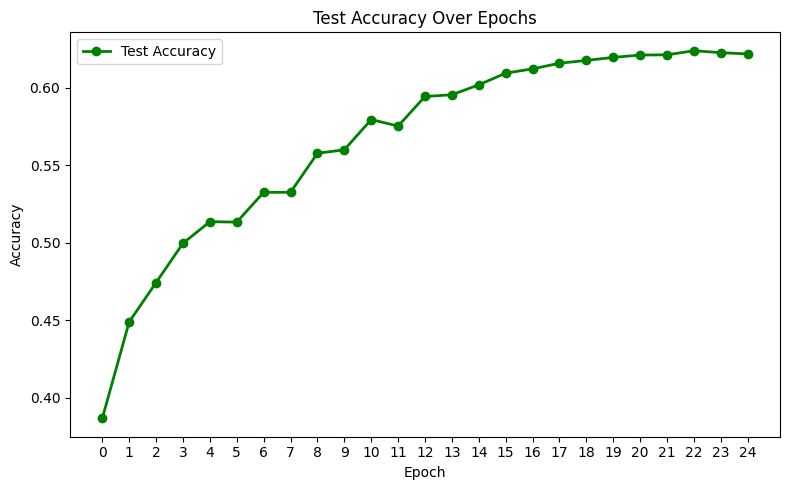

In [ ]:
import matplotlib.pyplot as plt

# Plotting test accuracy
plt.figure(figsize=(8, 5))
plt.plot(test_accuracies, label='Test Accuracy', color='green', linewidth=2, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(len(test_accuracies)))  # Show ticks for each epoch
plt.legend()
plt.tight_layout()
plt.show()


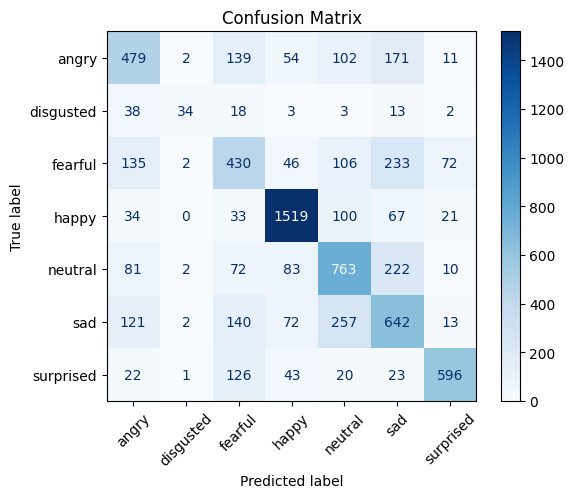

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Classification Report:

              precision    recall  f1-score   support

       angry     0.5264    0.5000    0.5128       958
   disgusted     0.7907    0.3063    0.4416       111
     fearful     0.4489    0.4199    0.4339      1024
       happy     0.8346    0.8563    0.8453      1774
     neutral     0.5648    0.6188    0.5906      1233
         sad     0.4683    0.5148    0.4905      1247
   surprised     0.8221    0.7172    0.7661       831

    accuracy                         0.6218      7178
   macro avg     0.6365    0.5619    0.5830      7178
weighted avg     0.6263    0.6218    0.6214      7178



Softmax for Image in each class

In [ ]:
from PIL import Image
import torch.nn.functional as F

# ✅ Function to predict and print softmax probabilities
def predict_softmax(img_path):
    model.eval()
    image = Image.open(img_path).convert("L")  # Grayscale
    image = transform(image).unsqueeze(0).to(device)  # [1, 1, 64, 64]

    with torch.no_grad():
        logits = model(image)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    print("📊 Softmax Emotion Probabilities:")
    for i, prob in enumerate(probs):
        print(f"{class_names[i]}: {prob:.4f}")

    plt.figure(figsize=(8, 4))
    plt.bar(class_names, probs, color='skyblue')
    plt.title("Emotion Softmax Prediction")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

#😐

📊 Softmax Emotion Probabilities:
angry: 0.0991
disgusted: 0.0137
fearful: 0.0260
happy: 0.0224
neutral: 0.6192
sad: 0.2112
surprised: 0.0083


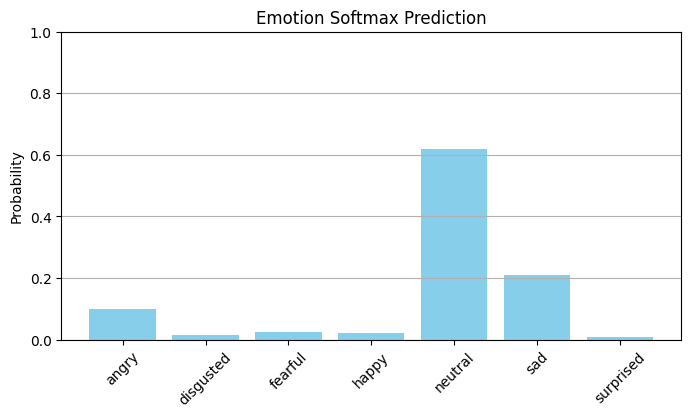

In [ ]:
neutral_image_path = "/kaggle/input/emotion-detection-fer/test/neutral/im123.png"
predict_softmax(neutral_image_path)

#😃

📊 Softmax Emotion Probabilities:
angry: 0.0452
disgusted: 0.0309
fearful: 0.0240
happy: 0.7348
neutral: 0.1047
sad: 0.0325
surprised: 0.0279


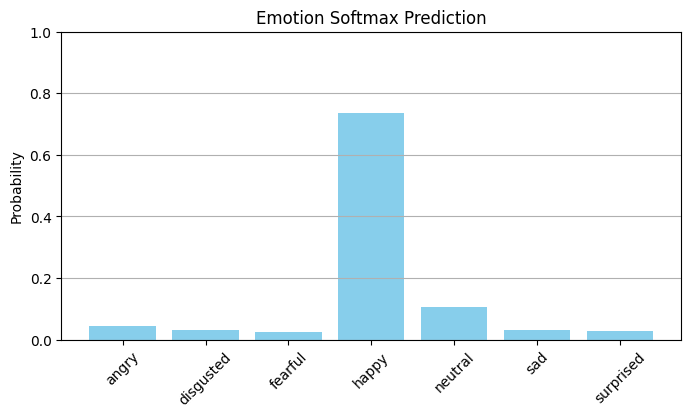

In [ ]:
happy_image_path = "/kaggle/input/emotion-detection-fer/test/happy/im123.png"
predict_softmax(happy_image_path)

#😞

📊 Softmax Emotion Probabilities:
angry: 0.0257
disgusted: 0.0121
fearful: 0.0867
happy: 0.0256
neutral: 0.0456
sad: 0.7971
surprised: 0.0072


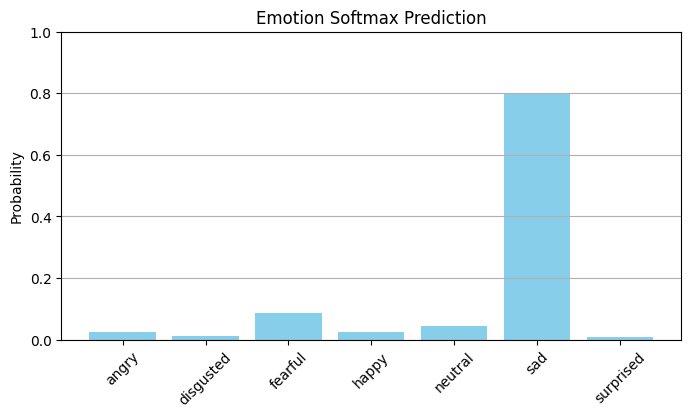

In [ ]:
sad_image_path = "/kaggle/input/emotion-detection-fer/test/sad/im321.png"
predict_softmax(sad_image_path)

#😠

📊 Softmax Emotion Probabilities:
angry: 0.7543
disgusted: 0.0138
fearful: 0.0546
happy: 0.0079
neutral: 0.1013
sad: 0.0416
surprised: 0.0266


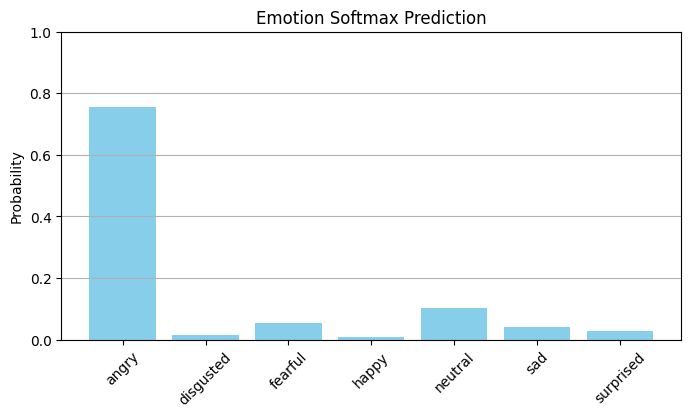

In [ ]:
angry_image_path = "/kaggle/input/emotion-detection-fer/test/angry/im123.png"
predict_softmax(angry_image_path)

#😯

📊 Softmax Emotion Probabilities:
angry: 0.0215
disgusted: 0.0398
fearful: 0.0249
happy: 0.0305
neutral: 0.0341
sad: 0.0347
surprised: 0.8145


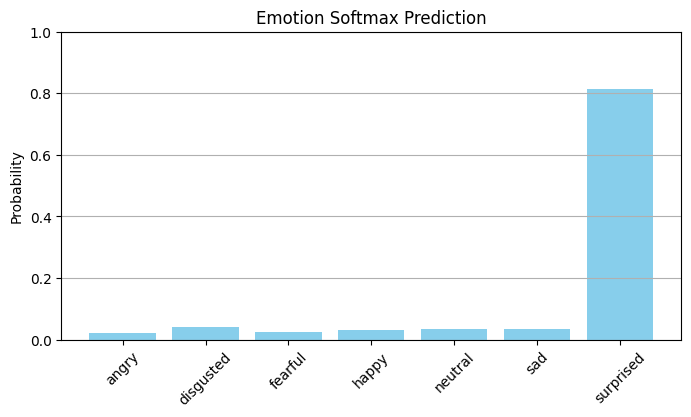

In [ ]:
surprised_image_path = "/kaggle/input/emotion-detection-fer/test/surprised/im123.png"
predict_softmax(surprised_image_path)

#🤮

📊 Softmax Emotion Probabilities:
angry: 0.1572
disgusted: 0.3026
fearful: 0.2068
happy: 0.0511
neutral: 0.0439
sad: 0.1966
surprised: 0.0417


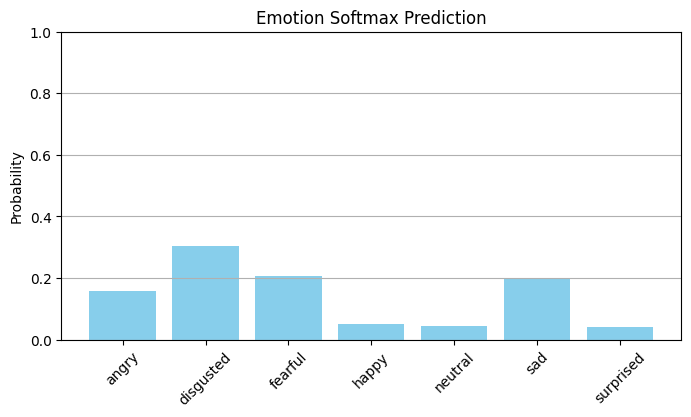

In [ ]:
disgusted_image_path = "/kaggle/input/emotion-detection-fer/test/disgusted/im5.png"
predict_softmax(disgusted_image_path)

#😨

📊 Softmax Emotion Probabilities:
angry: 0.1120
disgusted: 0.0925
fearful: 0.4916
happy: 0.0118
neutral: 0.0309
sad: 0.2329
surprised: 0.0283


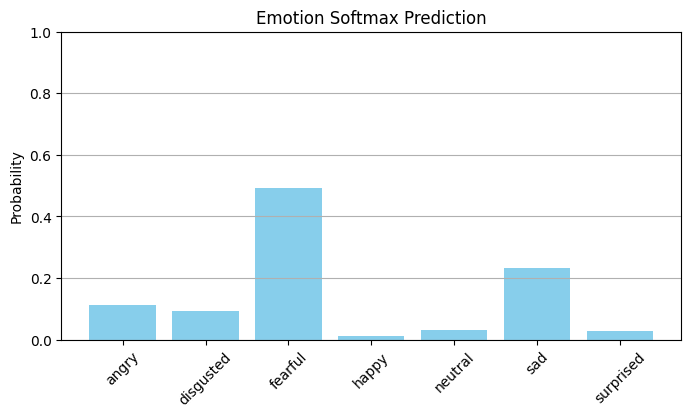

In [ ]:
fearful_image_path = "/kaggle/input/emotion-detection-fer/test/fearful/im78.png"
predict_softmax(fearful_image_path)

Accessing the model above:

In [ ]:

import os
print("Current working directory:", os.getcwd())


Current working directory: /content


Downloading the Model

In [ ]:
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>